## Optimization
## Project 1 – Linear Programming

### Group 17
#### Team Members: Jordan Ehlinger, Laurenz Pehl, Bindu Raghu Naga, Cassie Ren

Problem Description
Marketing budgets now comprise 11 percent of total company budgets, based on a CMO survey
sponsored by the Fuqua School of Business at Duke University, Deloitte LLP, and the American
Marketing Association. However, the effectiveness of marketing varies significantly: on the one hand,
P&G cut more than $100 million in digital marketing spending because their digital ads were largely
ineffective; on the other hand, Netflix plans a 54% boost in ad spending because they got very positive
feedback in international markets

In [1]:
# !pip install gurobipy

In [1]:
import numpy as np
import gurobipy as gp

from gurobipy import *
from gurobipy import quicksum
from gurobipy import Model
from gurobipy import GRB
import pandas as pd

In [2]:
# reading the ROI data from provided Excel "ROI_data"
ROI = pd.read_csv(r'/Users/cassieren/Documents/MSBA/Fall 2023/RM294/Projects/Project 1/ROI_data.csv')
ROI = ROI.set_index('Platform') # set index of ROI
var_names = ROI.columns.tolist()
ROI


,Print,TV,SEO,AdWords,Facebook,LinkedIn,Instagram,Snapchat,Twitter,Email
Platform,,,,,,,,,,
ROI,0.031,0.049,0.024,0.039,0.016,0.024,0.046,0.026,0.033,0.044
Second Firms ROI Estimate,0.049,0.023,0.024,0.039,0.044,0.046,0.026,0.019,0.037,0.026


In [3]:
df_roi = pd.read_csv(r"/Users/cassieren/Documents/MSBA/Fall 2023/RM294/Projects/Project 1/roi_mat.csv")

# converting the percentages to decimals
for col in var_names:
    df_roi[col] = df_roi[col].apply(lambda x : x/100)

df_roi.rename(columns = {'Unnamed: 0':'Months'},inplace=True)
    
df_roi

,Months,Print,TV,SEO,AdWords,Facebook,LinkedIn,Instagram,Snapchat,Twitter,Email
0,January,0.040,0.036,0.024,0.039,0.030,0.035,0.036,0.0225,0.035,0.035
1,February,0.040,0.039,0.027,0.038,0.043,0.032,0.027,0.0180,0.037,0.035
2,March,0.035,0.029,0.031,0.038,0.024,0.041,0.037,0.0260,0.042,0.025
3,April,0.038,0.031,0.024,0.044,0.024,0.038,0.037,0.0250,0.036,0.029
4,May,0.035,0.032,0.019,0.034,0.027,0.027,0.039,0.0220,0.045,0.039
5,June,0.040,0.032,0.027,0.034,0.034,0.030,0.045,0.0210,0.038,0.041
6,July,0.039,0.036,0.020,0.044,0.039,0.037,0.043,0.0180,0.040,0.038
7,August,0.042,0.033,0.028,0.042,0.020,0.037,0.036,0.0150,0.044,0.043
8,September,0.041,0.028,0.025,0.042,0.029,0.037,0.028,0.0250,0.040,0.034
9,October,0.030,0.030,0.031,0.046,0.031,0.033,0.032,0.0230,0.025,0.032


#### Question 3:
#### Formulate the marketing budget allocation problem as a linear program. Use gurobi to find the optimal budget allocation.

In [5]:
from gurobipy import Model, GRB, quicksum
import pandas as pd
import numpy as np

# Define the budget in millions of dollars
budget = 10

opt_mod_1 = Model(name="linearprogram")

var_names = ROI.columns.tolist()
roi = ROI.iloc[0].values

#constraint 1 : first 10 contrains that allocation can't be greater than $3M
x = opt_mod_1.addVars(var_names, lb=0, ub=3, name=var_names)

# Set up the objective function
obj_fn = opt_mod_1.setObjective(quicksum(roi[i] * x[var] for i, var in enumerate(var_names)), GRB.MAXIMIZE)

#Constraint 2: The amount invested in Print and TV should be no more than the amount spent on Facebook and Email.
#Print and TV have a coefficient of 1, indicating they contribute positively to the left side of the inequality, while Facebook and Email have a coefficient of -1,
#indicating they contribute negatively to the right side of the inequality.

#Constraint 3: The total amount used in social media (Facebook, LinkedIn, Instagram, Snapchat, and Twitter) should be at least twice that of SEO and AdWords.
#the social media channels have coefficients of 2, indicating they contribute positively to the left side of the inequality, while SEO and AdWords have coefficients of -1,
#indicating they contribute negatively to the right side of the inequality.

#Constraint 4: The total budget allocated should not exceed $10M.

# Define constraints
constraint_coeffs = [
    [1, 1, 0, 0, -1, 0, 0, 0, 0, -1],  # Constraint 2
    [0, 0, 2, 2, -1, -1, -1, -1, -1, 0],  # Constraint 3
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]  # Constraint 4
]

constraint_rhs = [0, 0, budget]  # RHS of constraints

#0: RHS of Constraint 11 (Print and TV <= Facebook and Email).
#0: RHS of Constraint 12 (Social Media >= 2 * SEO and AdWords).
#budget: RHS of Constraint 13 (Total budget <= $10 million).

# Add constraints to the model
for i, coeff in enumerate(constraint_coeffs):
    opt_mod_1.addConstr(quicksum(coeff[j] * x[var_names[j]] for j in range(len(var_names))) <= constraint_rhs[i])

# Optimize the model
opt_mod_1.Params.OutputFlag = 0  # Suppress Gurobi output
opt_mod_1.optimize()

# Print the results
if opt_mod_1.status == GRB.OPTIMAL:
    print("Optimal Budget Allocation:")
    budget_allocations = [x[var].x for var in var_names]
    df_allocations_1 = pd.DataFrame({"Platform": var_names, "Budget Allocation ($M)": budget_allocations})
    print(df_allocations_1)
    print(f"Total ROI: ${opt_mod_1.objVal:.4f}M")
else:
    print("No solution found.")


Optimal Budget Allocation:
    Platform  Budget Allocation ($M)
0      Print                     0.0
1         TV                     3.0
2        SEO                     0.0
3    AdWords                     1.0
4   Facebook                     0.0
5   LinkedIn                     0.0
6  Instagram                     3.0
7   Snapchat                     0.0
8    Twitter                     0.0
9      Email                     3.0
Total ROI: $0.4560M


#### This means that the maximum expected ROI should be $456,000. $3M should be allocated towards TV, Instagram, and Email, and USD 1M should be allocated towards AdWords. We should not allocate any budget to the remaining channels.


#### Question 4
Your boss is happy to see the promising results presented by the marketing department. However, your boss is also very concerned because your boss recalls being somewhat disappointed after following such recommendations in the past. To be cautious about the decision, your team has decided to get another opinion about the ROI data and rerun the analysis. The second consulting firm returns the estimates of the ROI data in the table below (also in the CSV file mentioned above). You are asked to compare the two optimal allocations from these two ROI estimates.

In [6]:
from gurobipy import Model, GRB, quicksum
import pandas as pd
import numpy as np

# Define the budget in millions of dollars
budget = 10

opt_mod_2 = Model(name="linearprogram")

var_names = ROI.columns.tolist()
roi = ROI.iloc[1].values #use he second roi data

#constraint 1 : first 10 contrains that allocation can't be greater than $3M
x = opt_mod_2.addVars(var_names, lb=0, ub=3, name=var_names)

# Set up the objective function
obj_fn = opt_mod_2.setObjective(quicksum(roi[i] * x[var] for i, var in enumerate(var_names)), GRB.MAXIMIZE)

#Constraint 2: The amount invested in Print and TV should be no more than the amount spent on Facebook and Email.
#Print and TV have a coefficient of 1, indicating they contribute positively to the left side of the inequality, while Facebook and Email have a coefficient of -1,
#indicating they contribute negatively to the right side of the inequality.

#Constraint 3: The total amount used in social media (Facebook, LinkedIn, Instagram, Snapchat, and Twitter) should be at least twice that of SEO and AdWords.
#the social media channels have coefficients of 2, indicating they contribute positively to the left side of the inequality, while SEO and AdWords have coefficients of -1,
#indicating they contribute negatively to the right side of the inequality.

#Constraint 4: The total budget allocated should not exceed $10M.

# Define constraints
constraint_coeffs = [
    [1, 1, 0, 0, -1, 0, 0, 0, 0, -1],  # Constraint 2
    [0, 0, 2, 2, -1, -1, -1, -1, -1, 0],  # Constraint 3
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]  # Constraint 4
]

constraint_rhs = [0, 0, budget]  # RHS of constraints

#0: RHS of Constraint 11 (Print and TV <= Facebook and Email).
#0: RHS of Constraint 12 (Social Media >= 2 * SEO and AdWords).
#budget: RHS of Constraint 13 (Total budget <= $10 million).

# Add constraints to the model
for i, coeff in enumerate(constraint_coeffs):
    opt_mod_2.addConstr(quicksum(coeff[j] * x[var_names[j]] for j in range(len(var_names))) <= constraint_rhs[i])

# Optimize the model
opt_mod_2.Params.OutputFlag = 0  # Suppress Gurobi output
opt_mod_2.optimize()

# Print the results
if opt_mod_2.status == GRB.OPTIMAL:
    print("Optimal Budget Allocation:")
    budget_allocations = [x[var].x for var in var_names]
    df_allocations_2 = pd.DataFrame({"Platform": var_names, "Budget Allocation ($M)": budget_allocations})
    print(df_allocations_2)
    print(f"Total ROI: ${opt_mod_2.objVal:.4f}M")
else:
    print("No solution found.")


Optimal Budget Allocation:
    Platform  Budget Allocation ($M)
0      Print                     3.0
1         TV                     0.0
2        SEO                     0.0
3    AdWords                     1.0
4   Facebook                     3.0
5   LinkedIn                     3.0
6  Instagram                     0.0
7   Snapchat                     0.0
8    Twitter                     0.0
9      Email                     0.0
Total ROI: $0.4560M


#### The maximum ROI remains consistent at USD $456,000, just as it was with the first set of ROI data. However, the distribution of the budget among various platforms has been altered. In this scenario, a budget of USD 3 million should be assigned to Print, Facebook, and LinkedIn, while AdWords should receive an allocation of $1 million.


#### Question 5
Are the allocations the same? Assuming the first ROI data is correct, if you were to use the second allocation (the allocation that assumed the second ROI data was correct) how much lower would the objective be relative to the optimal objective (the one that uses the first ROI
data and the first allocation)? Assuming the second ROI data is correct, if you used the first allocation how much lower would the objective be relative to the optimal objective? Do you think the third constraint above, based on your boss’ experience, is useful?

#### The company will distribute the budget across four distinct platforms in both scenarios. However, the selected platforms for allocation and the allocated amounts differ between the two cases. The following provides a comparison of these variations:

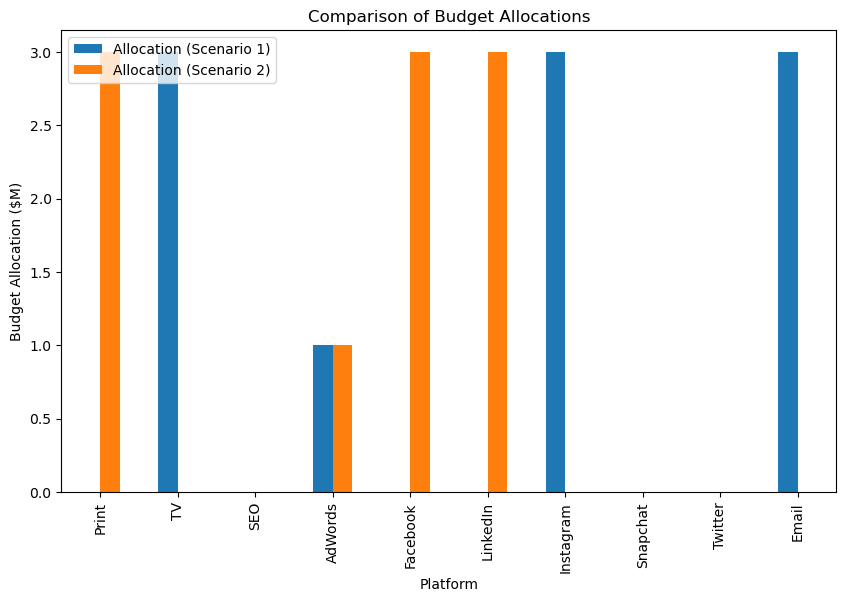

,Platform,Allocation (Scenario 1),Allocation (Scenario 2)
0,Print,0.0,3.0
1,TV,3.0,0.0
2,SEO,0.0,0.0
3,AdWords,1.0,1.0
4,Facebook,0.0,3.0
5,LinkedIn,0.0,3.0
6,Instagram,3.0,0.0
7,Snapchat,0.0,0.0
8,Twitter,0.0,0.0
9,Email,3.0,0.0


In [7]:
import matplotlib.pyplot as plt

df_compare_allocations = pd.DataFrame({
    'Platform': var_names,
    'Allocation (Scenario 1)': df_allocations_1['Budget Allocation ($M)'],
    'Allocation (Scenario 2)': df_allocations_2['Budget Allocation ($M)']
})

df_compare_allocations.plot(kind='bar', x='Platform', figsize=(10, 6))
plt.title('Comparison of Budget Allocations')
plt.xlabel('Platform')
plt.ylabel('Budget Allocation ($M)')
plt.legend(loc='upper left')
plt.show()

df_compare_allocations.head(10)


In [8]:
roi_1 = ROI.iloc[0].values
obj_val_1_2 = np.dot(roi_1, df_allocations_2['Budget Allocation ($M)'].values)
max_obj_1=opt_mod_1.objVal
print("Using the 1st set of ROI data with the 2nd allocation")
print("If we use the 1st set of ROI data and apply the 2nd allocation, our objective function would be: " + str(obj_val_1_2))
print("This would result in a lower objective function value compared to the original objective function value of: " + str(round(max_obj_1, 4)) + " by " + str(round(max_obj_1 - obj_val_1_2, 4)))
print("\n")

roi_2 = ROI.iloc[1].values
max_obj_2 = opt_mod_2.objVal
obj_val_2_1 = np.dot(roi_2, df_allocations_1['Budget Allocation ($M)'].values)
print("Using the 2nd set of ROI data with the 1st allocation")
print("If we use the 2nd set of ROI data and apply the 1st allocation, our objective function would be: " + str(obj_val_2_1))
print("This would result in a lower objective function value compared to the original objective function value of: " + str(round(max_obj_2,4)) + " by " + str(round(max_obj_2-obj_val_2_1,4)))


Using the 1st set of ROI data with the 2nd allocation
If we use the 1st set of ROI data and apply the 2nd allocation, our objective function would be: 0.252
This would result in a lower objective function value compared to the original objective function value of: 0.456 by 0.204


Using the 2nd set of ROI data with the 1st allocation
If we use the 2nd set of ROI data and apply the 1st allocation, our objective function would be: 0.264
This would result in a lower objective function value compared to the original objective function value of: 0.456 by 0.192


In [9]:
opt_mod = Model(name="linearprogram")  # Initializing the model
roi = ROI.iloc[0].values  # Reading the 1st set of ROI values

x = opt_mod.addVars(len(var_names), name=var_names) 
obj_fn = opt_mod.setObjective(quicksum(roi[i] * x[i] for i in range(len(var_names))), GRB.MAXIMIZE)
# Defining constraints
constraint_rhs = np.array([0, 0, budget])  # RHS of the constraints
constraint_coeffs = np.array([[1, 1, 0, 0, -1, 0, 0, 0, 0, -1]]) 
constraint_coeffs = np.append(constraint_coeffs, [[0, 0, 2, 2, -1, -1, -1, -1, -1, 0]], axis=0)  
constraint_coeffs = np.append(constraint_coeffs, [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], axis=0) 

n_constraints = len(constraint_rhs)  # Total number of constraints
constraints = []
n_vars = len(var_names)  # Total number of variables

for i in range(n_constraints):
    c = opt_mod.addConstr(
        quicksum(constraint_coeffs[i, j] * x[j] for j in range(n_vars)) <= constraint_rhs[i], name='Const_' + str(i))
    constraints.append(c)

opt_mod.Params.OutputFlag = 0  
opt_mod.optimize()  # Solving the model

# Printing the budget allocation in each channel
max_obj_1_w_o_boss = opt_mod.objVal
print('Objective Function Value: $' + str(round(opt_mod.objVal, 4)) + "M")
budget_alloc_1 = []
# Get values of the decision variables
for v in opt_mod.getVars():
    budget_alloc_1.append(v.x)

df_allocations_1 = pd.DataFrame(zip(var_names, budget_alloc_1), columns=['Platform', 'Budget Allocation ($M)'])
df_allocations_1.head(10)


Objective Function Value: $0.465M


,Platform,Budget Allocation ($M)
0,Print,0.0
1,TV,5.0
2,SEO,0.0
3,AdWords,0.0
4,Facebook,0.0
5,LinkedIn,0.0
6,Instagram,0.0
7,Snapchat,0.0
8,Twitter,0.0
9,Email,5.0


If we were to eliminate the third constraint, the maximum objective function value would increase by $9,000. However, it's important to consider that this approach focuses on just two channels, which may not be the most effective strategy due to the potential for diminishing returns.

The current objective function value is $456,000.

#### Question 6
To explore this further perform some analysis of how your optimal allocation would change based on changes in the ROI data. Use the first ROI data as your starting point. By how much could each advertising medium’s ROI increase or decrease and still result in the same optimal
allocation you found in step (3)?

In [10]:
import pandas as pd

# Define the sensitivity analysis parameters
platforms = var_names
min_roi = opt_mod_1.SAObjLow
curr_roi = ROI.iloc[0].values
max_roi = opt_mod_1.SAObjUp

# Create a DataFrame to store the sensitivity analysis results
df_sensitivity = pd.DataFrame({
    'Platform': platforms,
    'Min ROI': min_roi,
    'Curr ROI': curr_roi,
    'Max ROI': max_roi
})

# Display the sensitivity analysis results
print(df_sensitivity)


    Platform  Min ROI  Curr ROI  Max ROI
0      Print     -inf     0.031    0.049
1         TV    0.039     0.049    0.062
2        SEO     -inf     0.024    0.039
3    AdWords    0.033     0.039    0.046
4   Facebook     -inf     0.016    0.029
5   LinkedIn     -inf     0.024    0.039
6  Instagram    0.039     0.046      inf
7   Snapchat     -inf     0.026    0.039
8    Twitter     -inf     0.033    0.039
9      Email    0.029     0.044      inf


* Min ROI (Minimum ROI): The minimum ROI value that each platform's ROI can decrease to while still maintaining the same optimal budget allocation. A value of "-inf" indicates that the ROI for that platform can decrease to negative infinity without affecting the allocation.

* Curr ROI (Current ROI): The current ROI values for each platform based on the initial ROI data.

* Max ROI (Maximum ROI): The maximum ROI value that each platform's ROI can increase to while still maintaining the same optimal budget allocation. A value of "inf" indicates that the ROI for that platform can increase to positive infinity without affecting the allocation.

For example: for the "Print" platform:

* The minimum value of ROI can decrease to negative infinity, which means that the Print platform's ROI can decrease significantly without affecting the budget allocation.
* The current ROI for the Print platform is 0.031.
* The maximum ROI can increase to is 0.049, meaning that if the Print platform's ROI improves to greater than 0.049, the budget allocation will remain the same.

In contrast, for the "Instagram" platform:

* The minimum ROI can decrease to is 0.039, which means that the ROI of Instagram would need to decrease lower than 0.039 to impact the budget allocation.
* The current ROI for Instagram is 0.046.
* The maximum ROI can increase to positive infinity, indicating that even a substantial increase in Instagram's ROI won't change the budget allocation.

This results helps one to understand the flexibility and sensitivity of the budget allocation to changes in ROI for each advertising platform. Platforms with wider ranges of ROI values (both minimum and maximum) have more flexibility in terms of ROI changes without affecting the budget allocation. Conversely, platforms with narrower ranges are more sensitive to ROI fluctuations.

#### Question 7
Your boss has gained permission to reinvest half of the return. For example, if the marketing obtains a 4% return in January, the budget of February will be $10M + $10M × 4% × 50% = $10.2M. The monthly ROI for next year is given in an attached csv file. The three constraints
given by your boss are still in place for each month. What is the optimal allocation for each month?

The below code performs budget allocation optimization for each month, taking into account the reinvestment of half of the ROI from the previous month and adhering to the specified constraints. It provides the optimal budget allocation for each advertising platform for a series of months.

In [11]:
budget_n = budget 
#This initializes a variable budget_n with the initial budget value ($10M) for the first month. It will be used to update the budget in each iteration.
#for each month the budget will be 10 + 0.5*ROI(from previous month)

budget_allocation_list = [] #empty list to store the budget allocation results for each month.


for r in range(len(df_roi)):

    model = Model()
    x = model.addVars(len(var_names),name=var_names)

    # defining constrains
    constrain_rhs = np.array([3,3,3,3,3,3,3,3,3,3,0,0,budget_n])
    cont_eqn_coeff = np.identity(10)
    cont_eqn_coeff = np.append(cont_eqn_coeff,[[1,1,0,0,-1,0,0,0,0,-1]],axis=0)
    cont_eqn_coeff = np.append(cont_eqn_coeff,[[0,0,2,2,-1,-1,-1,-1,-1,0]],axis=0)
    cont_eqn_coeff = np.append(cont_eqn_coeff,[[1,1,1,1,1,1,1,1,1,1]],axis=0)

    #roi for each month
    roi = np.array(df_roi.loc[:,var_names])[r]

    # maximizing the roi for each month based on that month's roi
    objective = model.setObjective(quicksum(roi[i]*x[i] for i in range(len(var_names))),GRB.MAXIMIZE)

    n_constrains = len(constrain_rhs)
    con = []
    n_vars = len(var_names)

    for i in range(n_constrains):
        c = model.addConstr(quicksum(cont_eqn_coeff[i,j]*x[j] for j in range(n_vars))<=constrain_rhs[i],name='Const_'+str(i))
        #creates a constraint that enforces a linear relationship between decision variables x and coefficients from the cont_eqn_coeff matrix. 
        con.append(c)
        
    model.Params.OutputFlag = 0
    model.optimize() 

    roi_val = model.ObjVal
    budget_n = budget+0.5*roi_val # adding half of the roi to to the original budget i.e. $10M
    budget_allocation_list.append(model.X)

# outputing the budget allocations for each channel by months
coef_by_iterations = np.array(budget_allocation_list).T
coef_df = pd.DataFrame(coef_by_iterations, columns=df_roi['Months'], index=var_names)
coef_df.round(2)

Months,January,February,March,April,May,June,July,August,September,October,November,December
Print,3.00,3.00,0.0,0.0,1.2,3.00,0.00,2.71,0.61,0.0,3.00,3.00
TV,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,2.11
SEO,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00
AdWords,1.33,2.40,3.0,3.0,0.0,0.00,3.00,1.50,3.00,3.0,1.19,0.00
Facebook,0.00,3.00,0.0,0.0,0.0,0.00,1.21,0.00,0.00,0.0,0.00,3.00
LinkedIn,0.00,0.00,3.0,3.0,0.0,0.00,0.00,0.00,3.00,3.0,0.00,0.00
Instagram,2.67,0.00,1.2,3.0,3.0,3.00,3.00,0.00,0.00,3.0,3.00,0.00
Snapchat,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00
Twitter,0.00,1.79,3.0,1.2,3.0,1.21,3.00,3.00,3.00,0.0,0.00,0.00
Email,3.00,0.00,0.0,0.0,3.0,3.00,0.00,3.00,0.61,1.2,3.00,2.11


For reference:
* Initializing constrain_rhs:
constrain_rhs is an array that defines the right-hand side values of the constraints.
It contains 13 values, corresponding to the constraints for the 10 advertising platforms and the 3 additional constraints specified in your problem statement.
The first 10 values (3 for each platform) are set to 3, which enforces that each platform's budget allocation should not exceed $3 million, as per constraint c.
The last three values are initialized as follows:
The second-to-last value (0) corresponds to the constraint that the total amount used in social media should be at least twice the combined budget for SEO and AdWords (b).
The last value (budget_n) is used to dynamically specify the budget for the next month, where budget_n is updated based on the previous month's ROI.

* Initializing cont_eqn_coeff as an identity matrix:
cont_eqn_coeff is a coefficient matrix representing the linear coefficients of the decision variables (budget allocations).
It is initialized as a 10x10 identity matrix, where the main diagonal elements are 1, and all other elements are 0. This corresponds to the first 10 constraints ensuring that each platform's budget allocation is less than or equal to $3 million.
Appending additional constraint rows to cont_eqn_coeff:

* Three additional rows are appended to the cont_eqn_coeff matrix, representing the constraints related to the problem statement.
* The second-to-last row [1, 1, 0, 0, -1, 0, 0, 0, 0, -1] corresponds to the constraint that the amount invested in print and TV should be no more than the amount spent on Facebook and Email (a).
* The third-to-last row [0, 0, 2, 2, -1, -1, -1, -1, -1, 0] corresponds to the constraint that the total amount used in social media should be at least twice the combined budget for SEO and AdWords (b).
* The last row [1, 1, 1, 1, 1, 1, 1, 1, 1, 1] corresponds to the constraint that, for each platform, the amount invested should be no more than $3 million (c).

Looking at the table, one can analyze how the company's budget allocation or ROI varies across different advertising platforms over the course of the year. This information is essential for making decisions about where to allocate resources for marketing efforts. The specific values in the table provide insights into which platforms are performing well (high ROI) and which might need adjustments or reallocations of the budget. Additionally, this data can be used in optimization or budget allocation models to determine the optimal allocation of the marketing budget for each month based on certain constraints and objectives.

#### Question 8:
A stable budget is defined as a monthly allocation such that for each platform the monthly change in spend is no more than $1M. Is the allocation you found stable? If it isn’t, you do not need to solve a new optimization model. Describe how my might model this?

In [12]:
#computes the differences between consecutive months for each platform in the coef_df DataFrame. 
#It calculates how the budget allocation changes from one month to the next. The result is stored in the df_diff DataFrame.
df_diff = coef_df.diff(axis=1) 


df_diff.iloc[:, 0] = coef_df.iloc[:, 0]
df_diff = df_diff.iloc[:, 1:]

df_diff.round(3)


Months,February,March,April,May,June,July,August,September,October,November,December
Print,0.000,-3.000,0.000,1.200,1.800,-3.000,2.714,-2.105,-0.609,3.000,0.000
TV,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2.110
SEO,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
AdWords,1.062,0.604,0.000,-3.000,0.000,3.000,-1.500,1.500,0.000,-1.814,-1.186
Facebook,3.000,-3.000,0.000,0.000,0.000,1.212,-1.212,0.000,0.000,0.000,3.000
LinkedIn,0.000,3.000,0.000,-3.000,0.000,0.000,0.000,3.000,0.000,-3.000,0.000
Instagram,-2.667,1.203,1.797,0.000,0.000,0.000,-3.000,0.000,3.000,0.000,-3.000
Snapchat,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
Twitter,1.791,1.209,-1.796,1.796,-1.794,1.794,0.000,0.000,-3.000,0.000,0.000
Email,-3.000,0.000,0.000,3.000,0.000,-3.000,3.000,-2.391,0.592,1.799,-0.890


* The observed budget allocation fluctuations, exceeding the $1 million threshold in some months, highlight the need for a more consistent and stable marketing strategy. Abrupt changes in marketing spending across various platforms can disrupt ongoing campaigns and potentially affect customer engagement.

* The root cause of this instability lies in our current approach, where we optimize budget allocation by maximizing the ROI for each specific month based on that month's ROI. While this method allows for adaptability to varying market conditions, it also leads to pronounced budget shifts.

* To address this issue, we propose a refined strategy. Initially, we allocate budgets based on a single, predetermined ROI, as outlined in Part 1. Subsequently, we leverage the monthly ROIs to calculate the expected ROI for each specific month. To promote stability, we allocate half of this expected ROI increment to the following month. This approach aims to create a smoother transition between budget allocations, resulting in a more predictable and reliable marketing strategy.

Ultimately, achieving budget stability is crucial for maintaining a consistent brand presence and ensuring that marketing efforts yield reliable, long-term results.